# Numerical Exercises 4

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

# This is needed since in the output files only the last 50 blocks are the real simulation, while all the other data are equilibration data
NBLOCK = 50         

Titles = ["Potential Energy", "Total Energy", "Kinetic Energy", "Pressure", "Temperature", ""]
Y_Labels = ["U*/N", "E*/N", "K*/N", "P*", "T*", ""]

The final goal for these exercises is to simulate an Argon gas system (in which the interaction potential is assumed to be of the Lennard-Jones type) in its three different phases (solid, liquid, gas), via a Molecular Dynamics (MD) simulation. To do this some assumptions have been made, specifically:

1. The system can be considered as a microcanonical ensemble (NVE) (i.e. internal energy $E$, volume $V$ and particle number $N$ are conserved)
2. The system is periodic in each direction (i.e. there are no boundary effects)
3. The interaction can be ignored after a certain cut-off radius $r_c$

To this, a specific code has been provided which relies on the Verlet algorithm to compute the particles velocities and positions at each simulation time step. The Verlet algorithm works according to the following expression: $$\vec{r}(t+\delta t)=2\vec{r}(t)-\vec{r}(t-\delta t)+\delta t^2\vec{a}(t)$$
It is then a two step algorithm (not self-starting) in which the forces are include via the acceleration term $\vec{a}(t)$. It also has the advantages of being time-reversible, efficient and capable of conserving the total energy and momentum (even at large $\delta t$).
The provided code also already takes care of the Periodic Boundary Condition (PBC) and cutoff radius for the potential. Furthermore, for this simulation reduced units have been used.

As a last note, I summarize here the parameters (in reduced units) used for the simulation:

<div align = 'center'>

| Phase | $\rho^*$ | $T^*$ | $r_c$ |
|:-----:|:--------:|:-----:|:-----:|
| Solid | 1.1 | 0.8 | 2.2|
| Liquid | 0.8 | 1.1 | 2.5 |
| Gas | 0.05 | 1.2 | 5.0 |

</div>

The chemical and physical properties of Argon are given by $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu. In the simulations $N = 108$ particles will be considered.

# Exercise 4.1

In this first exercise I am going to modify the provided code to include the computation of pressure ($P$) and its statistical error. This can be easily done recalling that, in a Lennard-Jones system, the pressure obeys the following equation (obtained exploiting the virial theorem): 
$$ P = \rho k_B T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$
And, if we use natural units (as in the provided code), it simply reduces to:
$$ P^* = \rho T^* + \frac{1}{3V^*} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48 \left[ \left(\frac{1}{|\vec{r}_i^* -\vec{r}_j^*|}\right)^{12} - 
\frac{1}{2} \left(\frac{1}{|\vec{r}_i^* -\vec{r}_j^*|}\right)^6 \right] \right\rangle $$
This has been added to the code by filling the walker property `walker[iw]` according to the last expression.

# Exercise 4.2

## 4.2.1

Once the code has been modified to include the computation of pressure, it is possible to run the simulation of the three Argon phases. Before doing that, the system has to be equilibrated. This procedure is necessary because the initial configuration of the system is not a stable configuration; in fact, since the the Verlet algorithm requires the initial positions and velocities to be externally fixed, the first task of the program is to initialize these variables from a fixed configuration. In particular, the particles are initially placed in a cubic FCC lattice and the velocities are randomly distributed along a Maxwell-Boltzmann distribution. Of course this configuration is, generally, far from the equilibrium at a given temperature/density and thus needs to be equilibrated. In particular we have to find a different starting temperature so that, after equilibration, the measured temperature matches the target value. To this, for each phase, I ran a simulation with a great number of steps (i.e. much greater then the number of steps per block that I am going to use in the final simulation) grouped in blocks of only one step (so that i could effectively evaluate the instant temperature changes). At the end, I graphed the instant temperature, compared the equilibrium temperature to the target value and calculated the new starting temperature as follows: $$T_{New}=T_{Old}+\Delta{T},\quad\Delta{T}=\bar{T}-T_{Eq}$$
Where $T_{Eq}$ is given by the average of the temperature in the last $100$ steps and $\bar{T}$ is the target temperature. Below I left the graphs from the last iteration of this procedure, along with the temperature update history. 

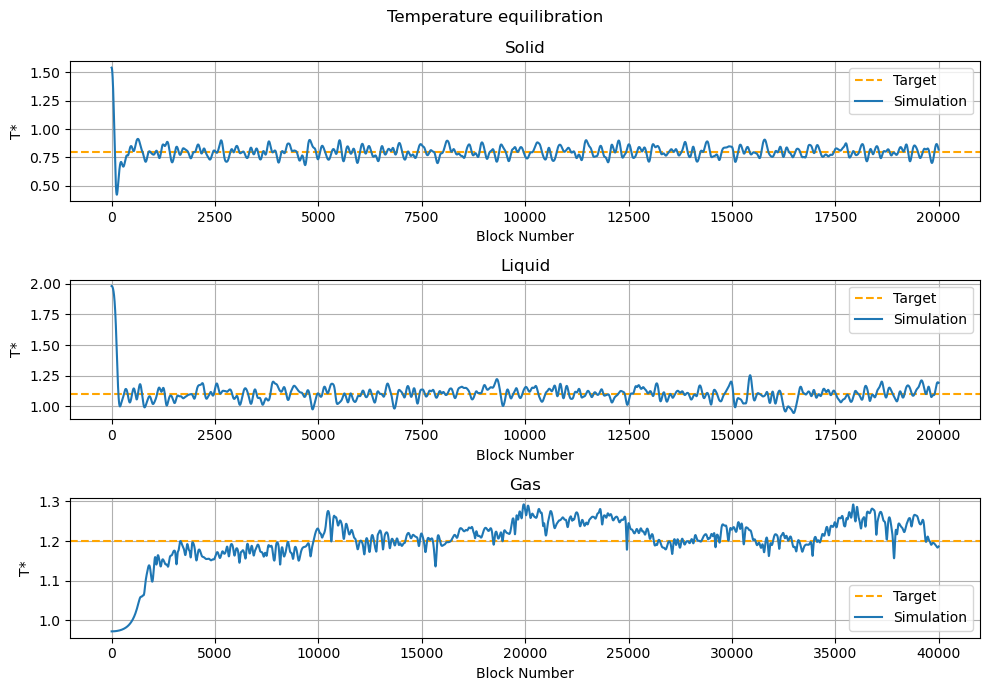

In [2]:
Phases = ["Solid", "Liquid", "Gas"]
phases_T_ne = []

Target_Ts = [0.8, 1.1, 1.2]

for idx, phase in enumerate(Phases):

    filename = "./MDNVE_MCNVT/NonEq/{}/output_temp.dat".format(phase)
    phase_T_ne = np.loadtxt(filename)
    phases_T_ne.append(phase_T_ne)

    plt.subplot(3, 1, idx + 1)
    plt.errorbar(phase_T_ne[:,0], phase_T_ne[:,1], label = "Simulation")
    plt.axhline(y = Target_Ts[idx], color = 'orange', linestyle = '--', label = "Target")
    plt.xlabel("Block Number")
    plt.ylabel("T*")
    plt.title(phase)
    plt.legend()
    plt.grid(True)

plt.suptitle("Temperature equilibration")
plt.gcf().set_size_inches(10, 7)
plt.tight_layout()
plt.show()    

In [3]:
ex_solid_T = 0.8
old_solid_T = [0.8, 1.19, 1.376, 1.465, 1.507, 1.525, 1.535, 1.54, 1.541263] # History of update start temperature
ob_solid_T = np.average(phases_T_ne[0][-100:-1,2])

# Average last 100 block temps and calculate offset => new simulation temperature
offset = ex_solid_T - ob_solid_T
new_temp = old_solid_T[-1] + offset

print("Observed Temp: " + ob_solid_T.astype(str))
print("Offset: " + offset.astype(str))
print("New Solid Temp: " + new_temp.astype(str))

Observed Temp: 0.7997195656565658
Offset: 0.0002804343434342771
New Solid Temp: 1.5415434343434344


In [84]:
ex_liquid_T = 1.1
old_liquid_T = [1.1, 1.862, 1.946, 1.961, 1.971, 1.980] # History of update start temperature
ob_liquid_T = np.average(phases_T_ne[1][-100:-1,2])

# Average last 100 block temps and calculate offset => new simulation temperature
offset = ex_liquid_T - ob_liquid_T
new_temp = old_liquid_T[-1] + offset

print("Observed Temp: " + ob_liquid_T.astype(str))
print("Offset: " + offset.astype(str))
print("New Solid Temp: " + new_temp.astype(str))

Observed Temp: 1.106350303030303
Offset: -0.006350303030302928
New Solid Temp: 1.973649696969697


In [85]:
ex_gas_T = 1.2
old_gas_T = [1.2, 0.974, 0.970, 0.972] # History of update start temperature
ob_gas_T = np.average(phases_T_ne[2][-100:-1,2])

# Average last 100 block temps and calculate offset => new simulation temperature
offset = ex_gas_T - ob_gas_T
new_temp = old_gas_T[-1] + offset

print("Observed Temp: " + ob_gas_T.astype(str))
print("Offset: " + offset.astype(str))
print("New Gas Temp: " + new_temp.astype(str))

Observed Temp: 1.2037506060606058
Offset: -0.0037506060606058433
New Gas Temp: 0.9682493939393941


As we can see, the temperature in all the three phases correctly oscillates around the target value, thus indicating the completion of the equilibration process. Before proceeding to the simulation results I may add a couple of notes on the gas phase. It is clear from the gas phase plot that the temperature is characterized by higher fluctuation in comparison with the other two phases, which has been partially addressed by allowing a longer equilibration (namely $40000$ steps instead of the $20000$ used in the solid and liquid phases). Anyway, since this is a purely thermodynamic effect (the lower density in the gas phase implies a lower collision probability and, in turn, a lower energy and temperature stabilization), the result cannot be further improved.

## 4.2.2

Once the equilibration procedure has been completed for each phase, I can then perform the actual simulations. In these simulations the initial configuration is not externally imposed as in the equilibration phase, but it's given by the output configuration (i.e. particles positions and velocities) from the equilibration step: the real simulation then "restarts" from where the equilibration has ended. In these simulations I always used a total of $10^5$ steps grouped into $50$ blocks of $2000$ steps (recall that the equilibration steps where $20000$, so ten times the steps in a simulation block). All the simulation have been performed with the parameters listed at the beginning of this notebook.

In the following graph I will summarize, for each phase, the observable that describe the system (evaluated using the data-blocking technique), i.e.:

- Potential energy per particle
- Total energy per particle
- Kinetic energy per particle
- Pressure
- Temperature

For each phase I also included a de-zoomed plot of the internal energy, with the vertical scale matching the other energies scale, so as to formulate some conclusions on the internal energy conservation.

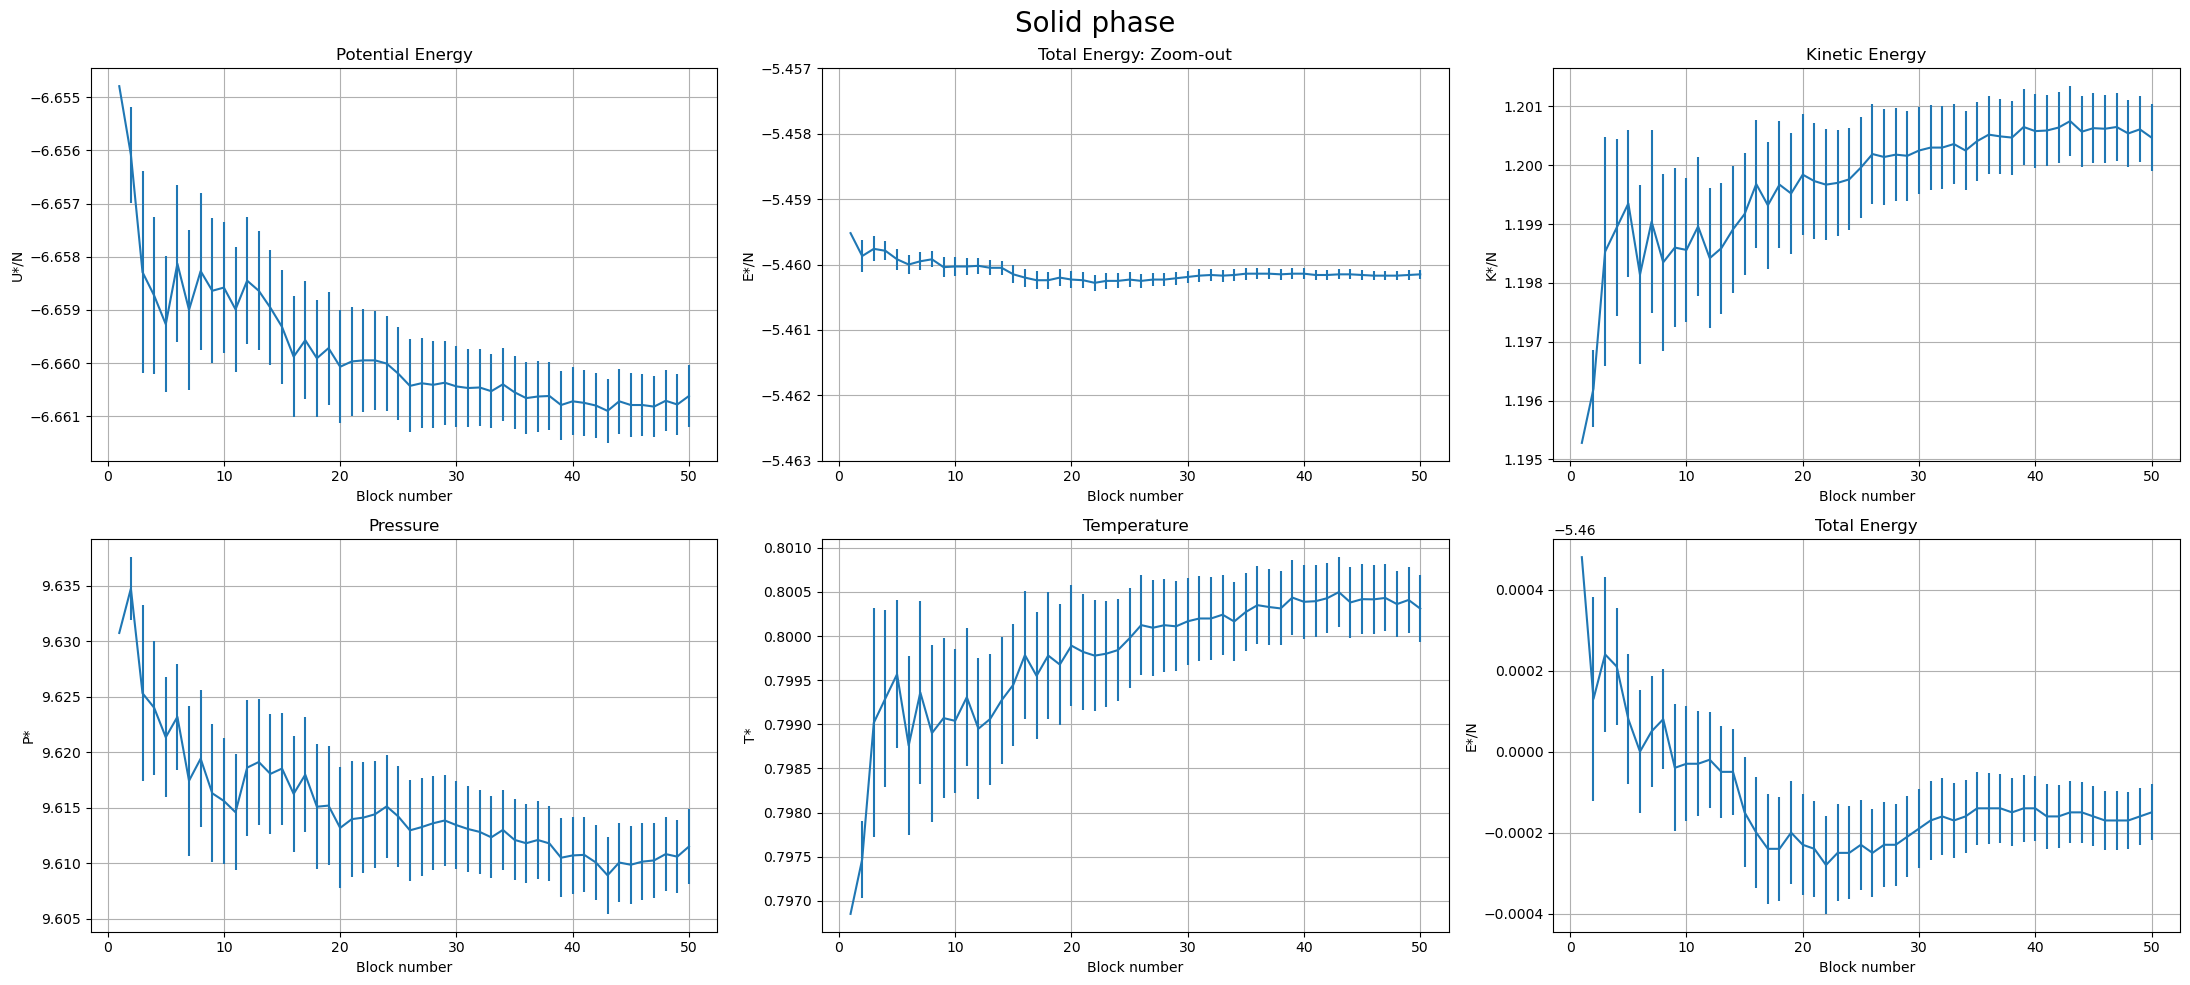

In [10]:
directory_name = "./MDNVE_MCNVT/Eq/Solid/"
directory = os.fsencode(directory_name)
    
plt.figure().set_size_inches(22, 10)

for idx, file in enumerate(os.listdir(directory)):

    filename = os.fsdecode(file)

    if filename != "input.in":

        data = np.loadtxt(directory_name + filename)

        if(idx == 2):
            
            avg = round(np.average(data[-NBLOCK:,2]), 3)
            y_ticks = np.linspace(avg - 3e-3, avg + 3e-3, 7)

            plt.subplot(2, 3, 2)

            plt.errorbar(data[-NBLOCK:,0], data[-NBLOCK:,2], yerr=data[-NBLOCK:,3])
            plt.yticks(y_ticks)
            plt.xlabel("Block number")
            plt.ylabel(Y_Labels[idx - 1])
            plt.title(Titles[idx - 1] + ": Zoom-out")
            plt.grid(True)

            plt.subplot(2, 3, 6)

        else:          

            plt.subplot(2, 3, idx)
        
        plt.errorbar(data[-NBLOCK:,0], data[-NBLOCK:,2], yerr=data[-NBLOCK:,3])
        plt.xlabel("Block number")
        plt.ylabel(Y_Labels[idx - 1])
        plt.title(Titles[idx - 1])
        plt.grid(True)

plt.gcf().suptitle("Solid phase", fontsize = 20)
plt.tight_layout()
plt.show()    

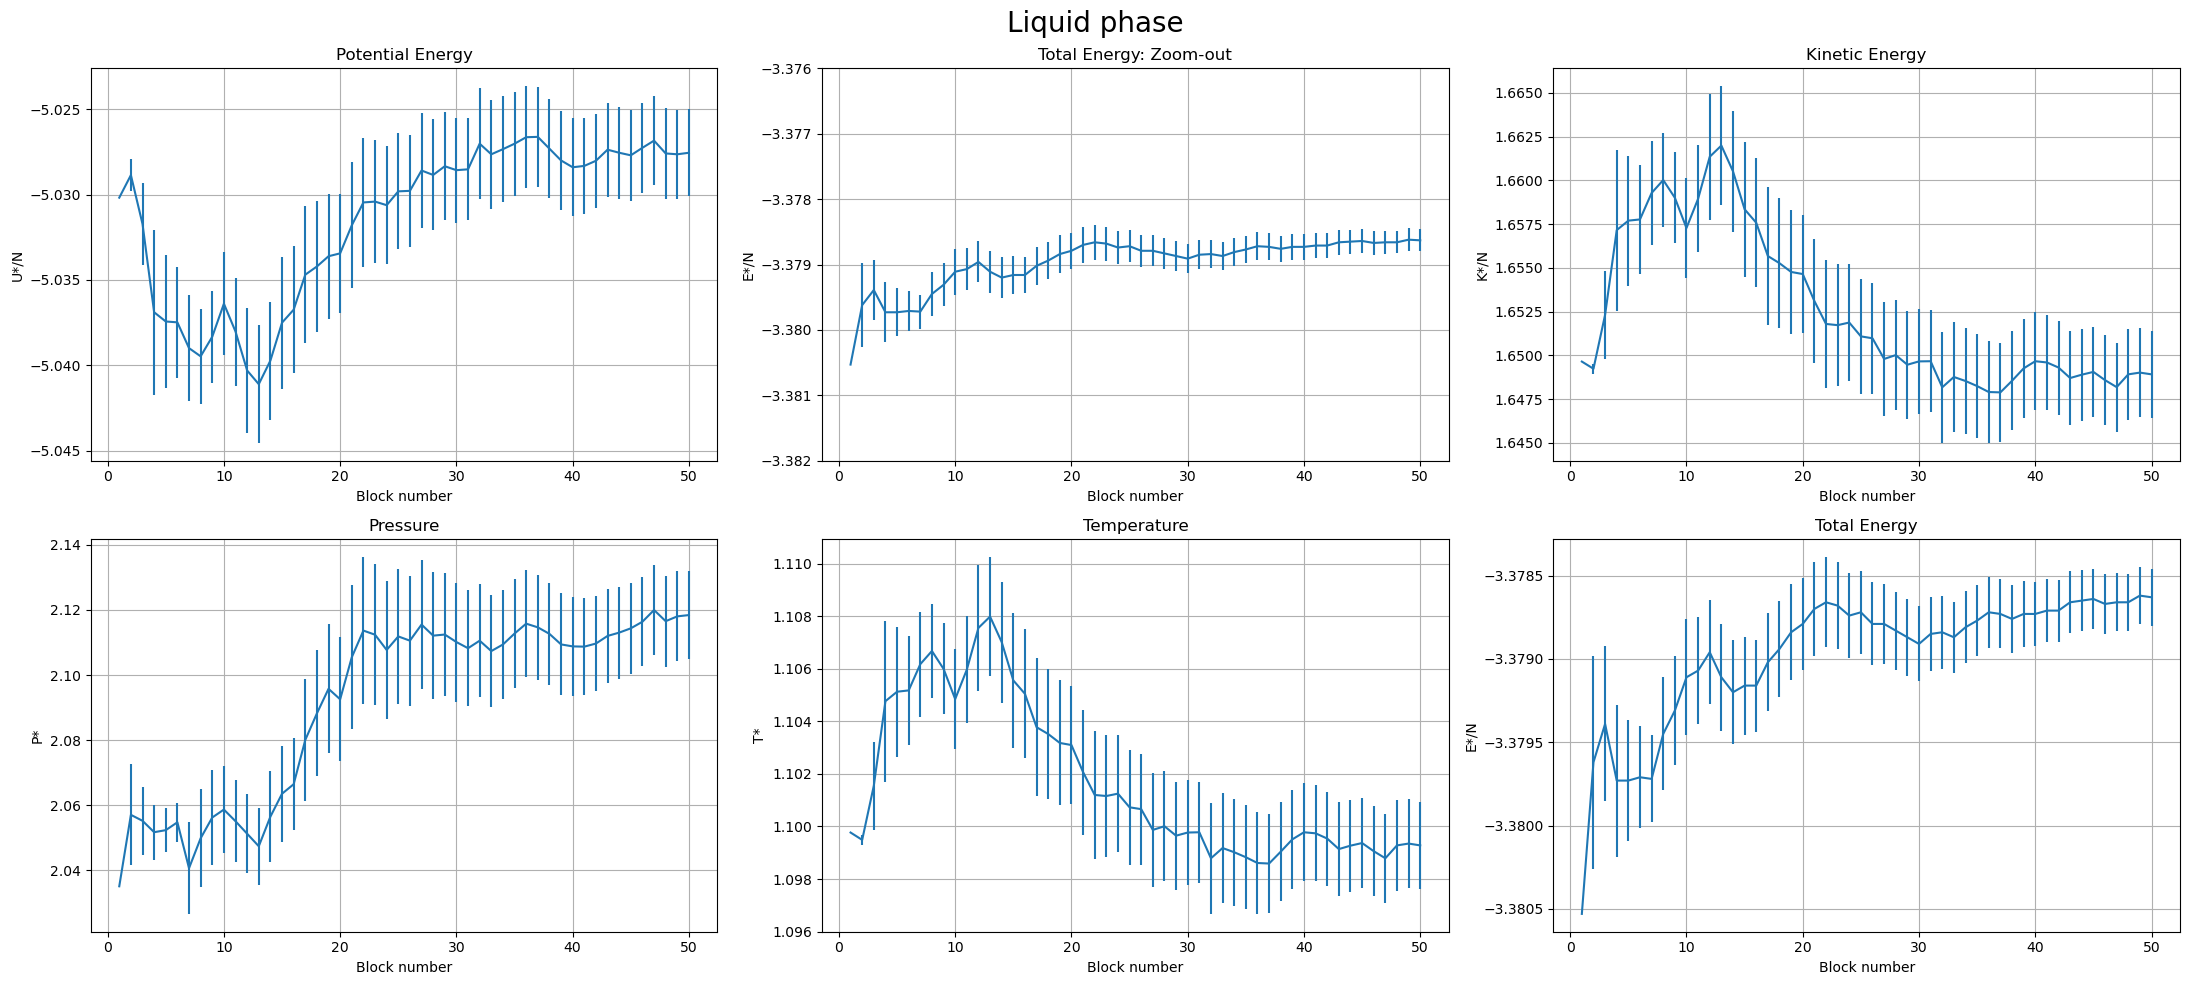

In [11]:
directory_name = "./MDNVE_MCNVT/Eq/Liquid/"
directory = os.fsencode(directory_name)
    
plt.figure().set_size_inches(22, 10)

for idx, file in enumerate(os.listdir(directory)):

    filename = os.fsdecode(file)

    if filename != "input.in":

        data = np.loadtxt(directory_name + filename)
        
        if(idx == 2):
            
            avg = round(np.average(data[-NBLOCK:,2]), 3)
            y_ticks = np.linspace(avg - 3e-3, avg + 3e-3, 7)

            plt.subplot(2, 3, 2)

            plt.errorbar(data[-NBLOCK:,0], data[-NBLOCK:,2], yerr=data[-NBLOCK:,3])
            plt.yticks(y_ticks)
            plt.xlabel("Block number")
            plt.ylabel(Y_Labels[idx - 1])
            plt.title(Titles[idx - 1] + ": Zoom-out")
            plt.grid(True)

            plt.subplot(2, 3, 6)

        else:          

            plt.subplot(2, 3, idx)
            
        plt.errorbar(data[-NBLOCK:,0], data[-NBLOCK:,2], yerr=data[-NBLOCK:,3])
        plt.xlabel("Block number")
        plt.ylabel(Y_Labels[idx - 1])
        plt.title(Titles[idx - 1])
        plt.grid(True)
        
plt.gcf().suptitle("Liquid phase", fontsize = 20)
plt.tight_layout()
plt.show()    

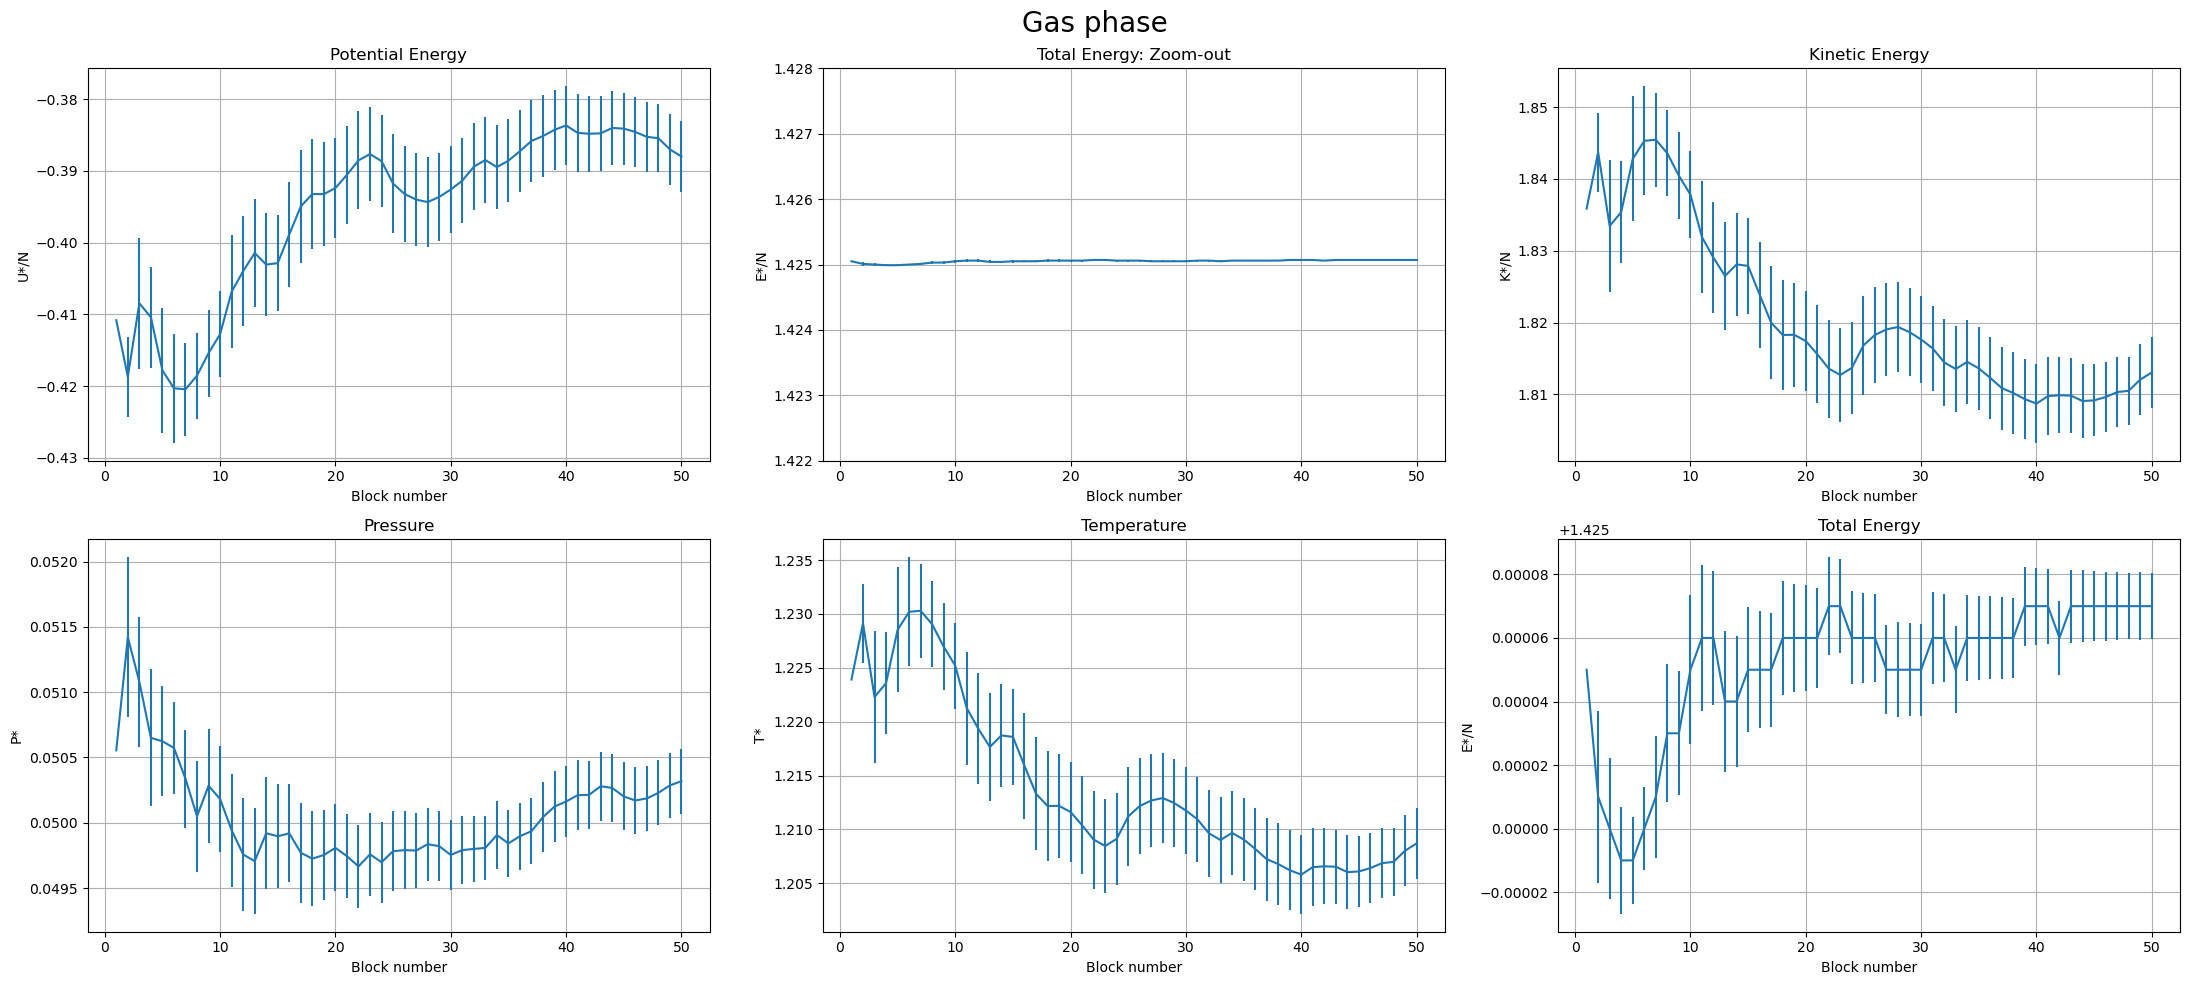

In [12]:
directory_name = "./MDNVE_MCNVT/Eq/Gas/"
directory = os.fsencode(directory_name)
    
plt.figure().set_size_inches(22, 10)

for idx, file in enumerate(os.listdir(directory)):

    filename = os.fsdecode(file)

    if filename != "input.in":

        data = np.loadtxt(directory_name + filename)

        if(idx == 2):
            
            avg = round(np.average(data[-NBLOCK:,2]), 3)
            y_ticks = np.linspace(avg - 3e-3, avg + 3e-3, 7)

            plt.subplot(2, 3, 2)

            plt.errorbar(data[-NBLOCK:,0], data[-NBLOCK:,2], yerr=data[-NBLOCK:,3])
            plt.yticks(y_ticks)
            plt.xlabel("Block number")
            plt.ylabel(Y_Labels[idx - 1])
            plt.title(Titles[idx - 1] + ": Zoom-out")
            plt.grid(True)

            plt.subplot(2, 3, 6)

        else:          

            plt.subplot(2, 3, idx)

        plt.errorbar(data[-NBLOCK:,0], data[-NBLOCK:,2], yerr=data[-NBLOCK:,3])
        plt.xlabel("Block number")
        plt.ylabel(Y_Labels[idx - 1])
        plt.title(Titles[idx - 1])
        plt.grid(True)

plt.gcf().suptitle("Gas phase", fontsize = 20)
plt.tight_layout()
plt.show()    

As we can see, in all three phases the internal energy remains almost constant (if we compare it to the other energies typical oscillation scale), thus confirming the NVE hypothesis. Furthermore we have a some other hints of coherence that verifies the used model, namely:

- Pressure increases as density increases (particle closer, thus more collisions): $P^{(s)} > P^{(l)} > P^{(g)}$
- Potential energy decreases as density increases (closer particles, thus radii closer to the potential well): $U^{(s)} > U^{(l)} > U^{(g)}$
- Kinetic energy and temperature are proportional